Accuracy: 0.7924662402274343
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.49      0.56       374

    accuracy                           0.79      1407
   macro avg       0.74      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407


Customer Segment Distribution:
 Segment
Loyal       3926
At Risk     1662
Standard     956
Dormant      488
Name: count, dtype: int64


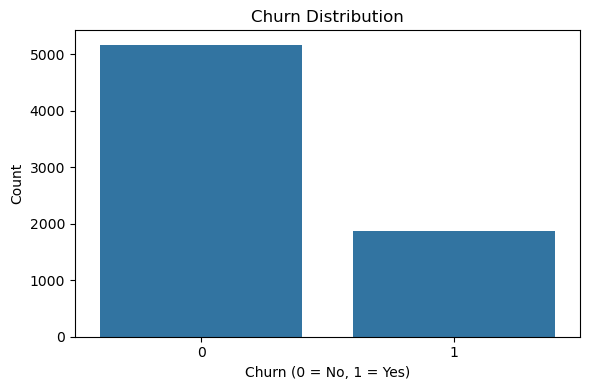

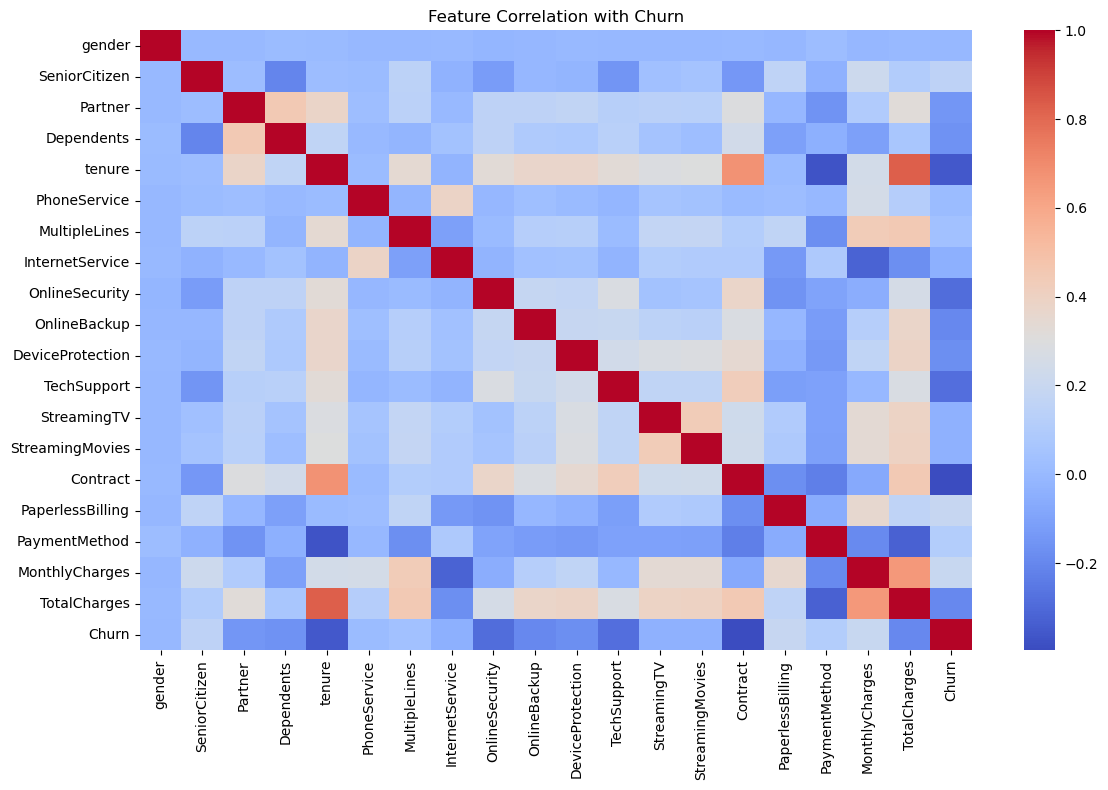

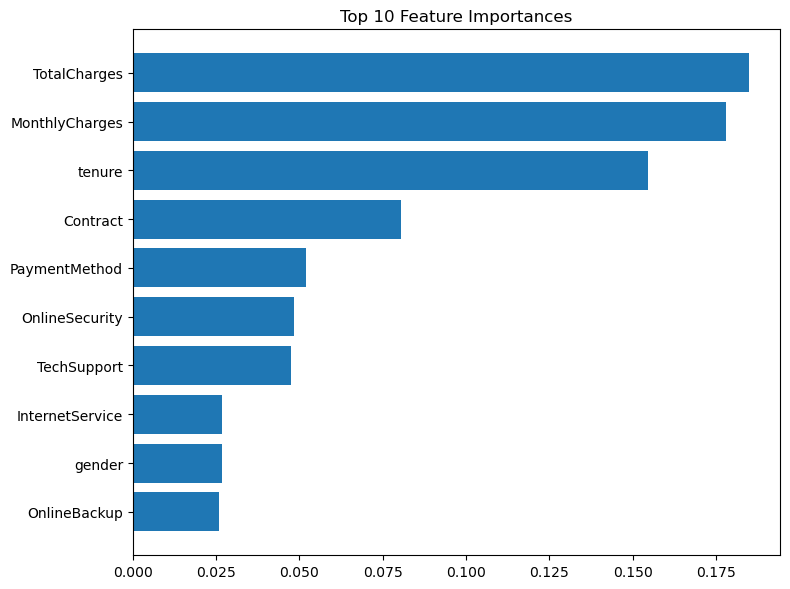

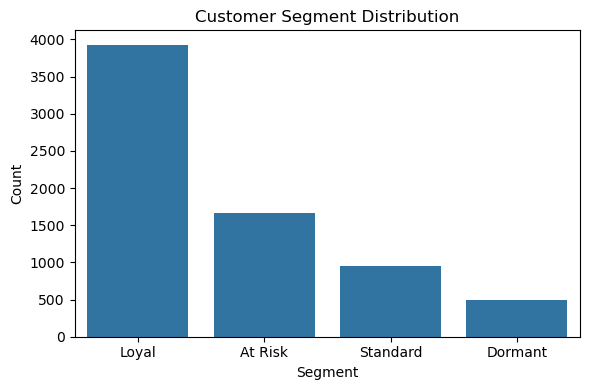

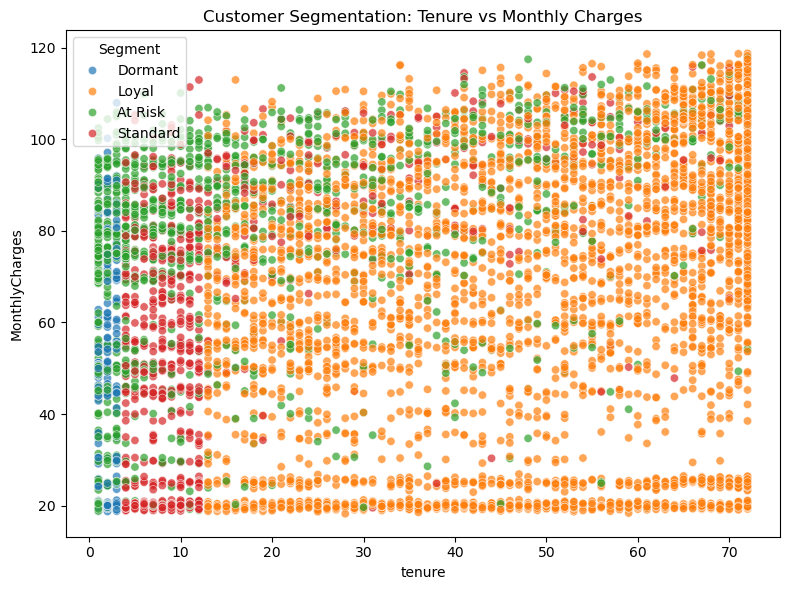


🔍 ELI5 Feature Importance (Permutation):



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import eli5
from eli5.sklearn import PermutationImportance

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
df = pd.read_csv(r'C:\Users\l\OneDrive\Desktop\Customer.csv')

# Convert 'TotalCharges' to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(subset=['TotalCharges'], inplace=True)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Save original df for visualization
df_original = df.copy()

# Drop 'customerID'
df_model = df.drop('customerID', axis=1)

# Label encode
cat_cols = df_model.select_dtypes(include='object').columns
le = LabelEncoder()
for col in cat_cols:
    df_model[col] = le.fit_transform(df_model[col])

# Split
X = df_model.drop('Churn', axis=1)
y = df_model['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict & evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Add churn_prob & segment to original df
df_original['churn_prob'] = model.predict_proba(X)[:, 1]

def segment(row):
    if row['churn_prob'] > 0.6:
        return "At Risk"
    elif row['churn_prob'] < 0.3 and row['tenure'] > 12:
        return "Loyal"
    elif row['tenure'] <= 3:
        return "Dormant"
    else:
        return "Standard"

df_original['Segment'] = df_original.apply(segment, axis=1)

# Segment distribution
print("\nCustomer Segment Distribution:\n", df_original['Segment'].value_counts())

# 1. Churn Count Plot
plt.figure(figsize=(6,4))
sns.countplot(data=df_original, x='Churn')
plt.title("Churn Distribution")
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 2. Feature Correlation Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df_model.corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation with Churn")
plt.tight_layout()
plt.show()

# 3. Feature Importances
importances = model.feature_importances_
indices = np.argsort(importances)[-10:]
plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()

# 4. Segment Distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df_original, x='Segment', order=df_original['Segment'].value_counts().index)
plt.title("Customer Segment Distribution")
plt.ylabel("Count")
plt.xlabel("Segment")
plt.tight_layout()
plt.show()

# 5. Monthly Charges vs. Tenure (colored by Segment)
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_original, x='tenure', y='MonthlyCharges', hue='Segment', alpha=0.7)
plt.title("Customer Segmentation: Tenure vs Monthly Charges")
plt.tight_layout()
plt.show()

print("ELI5 Feature Importance (Permutation):\n")

perm = PermutationImportance(model, random_state=42).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X.columns.tolist())  
print(perm)


df_original.to_csv("Churn_Segmented_Customers.csv", index=False)
